In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import threading
import setuptools
from numpy.linalg import norm
import matplotlib as mpl

from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from IPython.display import display, clear_output

%matplotlib inline
%load_ext cython

In [2]:
%%cython
# copy past some ODE solver in cython

cimport cython
import numpy as np
cimport numpy as np


cdef class Problem(object):
    cdef int N
    cdef double[:] dudt

    def __init__(self, int N):
        self.N = N
        self.dudt = np.zeros(N)

    cpdef double[:] rhs(self, double[:] u, double t):
        return np.zeros(self.N)

cdef class Method(object):
    cdef int N
    cdef double[:] step_result
    cdef double[:] rhs

    def __init__(self, N):
        self.N = N
        self.step_result = np.zeros((N,), dtype=np.double)
        self.rhs = np.zeros((N,), dtype=np.double)

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void step(self, double[:,::1] result, int i, int j, Problem f, double t, double dt):
        pass

cdef class MethodRK4(Method):
    cdef double[:] k1
    cdef double[:] k2
    cdef double[:] k3
    cdef double[:] tmp
    cdef double* k1p
    cdef double* k2p
    cdef double* k3p
    cdef double* tmpp

    def __init__(self, N):
        super(MethodRK4, self).__init__(N)
        self.k1 = np.zeros((N,), dtype=np.double)
        self.k2 = np.zeros((N,), dtype=np.double)
        self.k3 = np.zeros((N,), dtype=np.double)
        self.tmp = np.zeros((N,), dtype=np.double)
        self.k1p = &self.k1[0]
        self.k2p = &self.k2[0]
        self.k3p = &self.k3[0]
        self.tmpp = &self.tmp[0]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void step(self, double[:,::1] result, int i, int j, Problem f, double t, double dt):
        cdef double *pptr = &result[j, 0]
        cdef double *rptr = &result[i, 0]
        cdef double* tmp = &f.rhs(result[j, :], t)[0]

        # compute k1 and the next step
        for n in range(self.N):
            self.k1p[n] = dt * tmp[n]
            self.tmpp[n] = pptr[n] + 0.5 * self.k1p[n]

        # compute k2 and the next step
        tmp = &f.rhs(self.tmp, t + 0.5 * dt)[0]
        for n in range(self.N):
            self.k2p[n] = dt * tmp[n]
            self.tmpp[n] = pptr[n] + 0.5 * self.k2p[n]

        # compute k3 and the next step
        tmp = &f.rhs(self.tmp, t + 0.5 * dt)[0]
        for n in range(self.N):
            self.k3p[n] = dt * tmp[n]
            self.tmpp[n] = pptr[n] + self.k3p[n]

        # compute k4 and combine into result
        tmp = &f.rhs(self.tmp, t + dt)[0]
        for n in range(self.N):
            rptr[n] = pptr[n] + 1.0/6.0 * (
                    self.k1p[n] + 2.0 * self.k2p[n] + 2.0 * self.k3p[n] + dt * tmp[n])


@cython.boundscheck(False)
@cython.cdivision(True)
cdef double[:,:] __ODEsolve(Method method, Problem f, double a, double b, int N, double[::1] yInit):
    cdef double dt = (b - a) / N
    cdef double[:,::1] result = np.zeros((N+1, f.N), dtype=np.double)

    result[0, :] = yInit

    cdef double t
    cdef int i
    for i in range(1, N+1):
        t = a + i * dt
        method.step(result, i, i-1, f, t, dt)

    return result

cpdef double[:,:] ODEsolve(Problem f, double a, double b, int N, double[::1] yInit):
    cdef Method method = MethodRK4(f.N)
    return __ODEsolve(method, f, a, b, N, yInit)

cdef class L63(Problem):
    cdef double[:] para
    
    def __init__(self, double[:] para):
        super(L63, self).__init__(3)
        self.para = para

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cpdef double[:] rhs(self, double[:] u, double t):
        self.dudt[0] = self.para[0] * (u[1] - u[0])
        self.dudt[1] = -u[0] * u[2] + self.para[2] * u[0] - u[1]
        self.dudt[2] = u[0] * u[1] - self.para[1] * u[2]
        return self.dudt

In [3]:


# def some functions to handle the solver

class ODE_Solution(object):
    def __init__(self, t, y):
        self.t = t
        self.y = y

def solve_L63(p=np.array([10., 8./3., 13.926]), u0=[1,0,0], t_stop=1000, t_steps=100000):
    a = 0
    b = t_stop
    N = t_steps
    t = np.linspace(a, b, N+1)
    u0 = np.asarray(u0, dtype=float)
    solution = ODEsolve(L63(p), a, b, N, u0)
    
    return ODE_Solution(t, solution)

def u_fix(r, b=8./3.):
    u_0 = [0, 0, 0]
    u_p = [ np.sqrt(b * (r - 1)),  np.sqrt(b * (r - 1)), r - 1]
    u_m = [-np.sqrt(b * (r - 1)), -np.sqrt(b * (r - 1)), r - 1]
    return [u_0, u_p, u_m]

# 3) #

In [7]:
x = np.arange(-10,10,0.5)
y = np.arange(-10,10,0.5)

hit = 1e-4

Pr = 10
b = 8/3
r = 13.926

ufix = u_fix(r,b)

In [8]:
color = []

for i in x:
    new= []
    for k in y:
        solution = solve_L63(p=np.array(([Pr,b,r])), u0=[i,k,0])
        #print(solution.y[-1,:])
        if norm(solution.y[-1,:] - np.asarray(ufix[0]))<= hit:
            new.append(1)
        elif norm(solution.y[-1,:] - np.asarray(ufix[1]))<= hit:
            new.append(2)
        elif norm(solution.y[-1,:] - np.asarray(ufix[2]))<= hit:
            new.append(3)
        else:
            new.append(0)
    color.append(new)

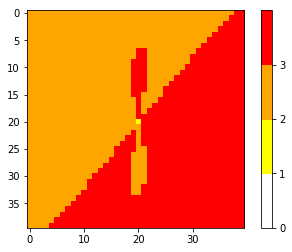

In [9]:
cmap = mpl.colors.ListedColormap(['white','yellow','orange','red'])
bounds=[0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(color,interpolation='nearest',
                    cmap = cmap,norm=norm)
plt.colorbar(img,cmap=cmap,
                norm=norm,boundaries=bounds,ticks=[0,1,2,3])



# The axes run from -10 to 10, due to some issues the point (0,0,0) is at (20,20). The colorcode ist yellow for u0, orange u+ and red u-. #

In [4]:
x = np.arange(-10,10,0.5)
y = np.arange(-10,10,0.5)

hit = 1e-4

Pr = 10
b = 8/3
r =24.06

ufix = u_fix(r,b)

In [5]:
color = []

for i in x:
    new= []
    for k in y:
        solution = solve_L63(p=np.array(([Pr,b,r])), u0=[i,k,0])
        #print(solution.y[-1,:])
        if norm(solution.y[-1,:] - np.asarray(ufix[0]))<= hit:
            new.append(1)
        elif norm(solution.y[-1,:] - np.asarray(ufix[1]))<= hit:
            new.append(2)
        elif norm(solution.y[-1,:] - np.asarray(ufix[2]))<= hit:
            new.append(3)
        else:
            new.append(0)
    color.append(new)

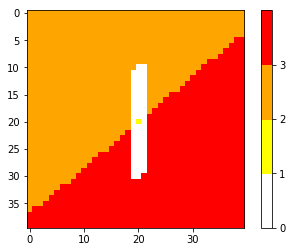

In [6]:
cmap = mpl.colors.ListedColormap(['white','yellow','orange','red'])
bounds=[0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(color,interpolation='nearest',
                    cmap = cmap,norm=norm)
plt.colorbar(img,cmap=cmap,
                norm=norm,boundaries=bounds,ticks=[0,1,2,3])

In [4]:
x = np.arange(-10,10,0.5)
y = np.arange(-10,10,0.5)

hit = 1e-4

Pr = 10
b = 8/3
r =24.7

ufix = u_fix(r,b)

In [5]:
color = []

for i in x:
    new= []
    for k in y:
        solution = solve_L63(p=np.array(([Pr,b,r])), u0=[i,k,0])
        #print(solution.y[-1,:])
        if norm(solution.y[-1,:] - np.asarray(ufix[0]))<= hit:
            new.append(1)
        elif norm(solution.y[-1,:] - np.asarray(ufix[1]))<= hit:
            new.append(2)
        elif norm(solution.y[-1,:] - np.asarray(ufix[2]))<= hit:
            new.append(3)
        else:
            new.append(0)
    color.append(new)

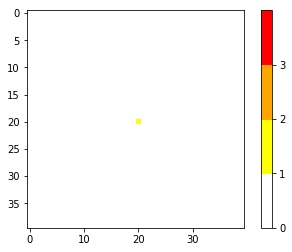

In [6]:
cmap = mpl.colors.ListedColormap(['white','yellow','orange','red'])
bounds=[0,1,2,3,4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(color,interpolation='nearest',
                    cmap = cmap,norm=norm)
plt.colorbar(img,cmap=cmap,
                norm=norm,boundaries=bounds,ticks=[0,1,2,3])